# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 

In [1]:
!nvidia-smi

Tue Aug  3 11:20:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q efficientnet
#попробуем решить задачу efficientnet'ом

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification', 'best-md']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
!pip freeze > requirements.txt

# Основные настройки

In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# Основные параметры, которые будут использоваться в дальнейшем

EPOCHS               = 5  
BATCH_SIZE           = 8
LR                   = 1e-3
VAL_SPLIT            = 0.15 

CLASS_NUM            = 10  # количество классов 
IMG_SIZE             = 224 
IMG_CHANNELS         = 3   
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория

In [7]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


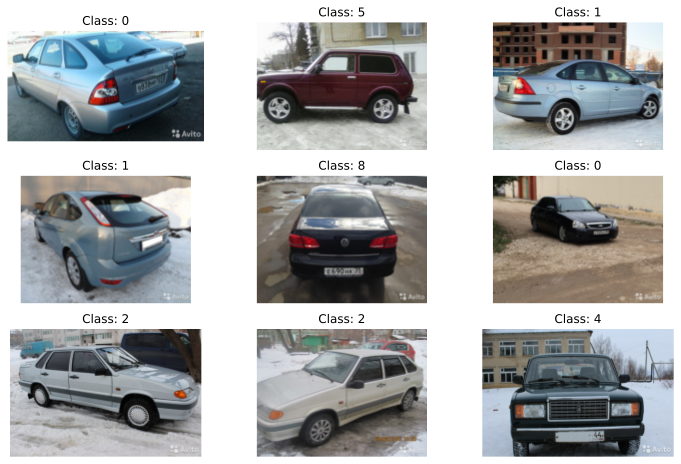

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

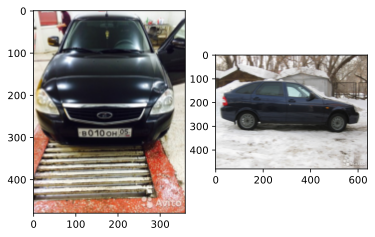

(360, 480) (640, 480)


In [13]:
img1 = PIL.Image.open(PATH+'/train/0/102137.jpg')
img2 = PIL.Image.open(PATH+'/train/0/100380.jpg')
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()
print(img1.size, img2.size)

Видно, что картинки могут иметь разные размеры

Еще примеры


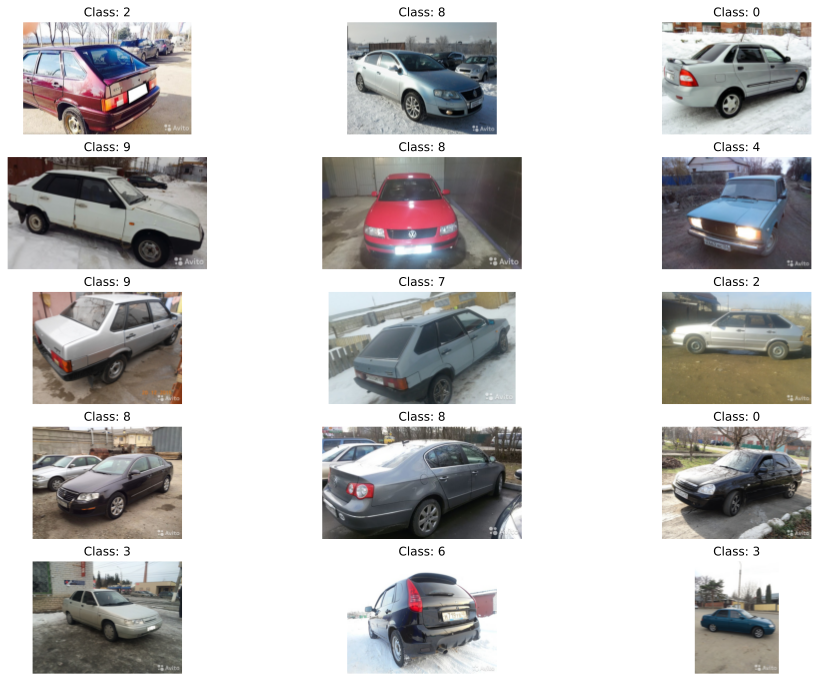

In [14]:
#посмотрим еще примеры картинок, чтобы предположить, что означают классы
print('Еще примеры')
plt.figure(figsize=(16,12))

random_image = train_df.sample(n=15)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(5,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

По картинкам можно предположить, что классы означают марку автомобиля

# Подготовка данных

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


### Аугментация данных

In [16]:
# У нас всего лишь 15561 обучающий пример. Это очень мало, поэтому нужно сделать аугментацию.
# Добавим новые параметры в ImageDataGenerator по сравнению в предыдущей версией

# с помощью этого класса можно создавать измененные картинки и подавать на обучение батчами, не сохраняя новые картинки в памяти
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    brightness_range=[0.75, 1.25], 
    #zoom_range=[0.5,1.5],
    rotation_range = 5, #поварачиваем картинке на угол [0,5] градусов
    width_shift_range=0.1,#процент от всего изображения, на который смещаем по ширине (сдвиг в диапазоне [0, 0.1])
    height_shift_range=0.1, #процент от всего изображения, на который смещаем по высоте
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [17]:
# Завернем наши данные в генератор:

# в PATH+'train/' есть папки с классами, в которых хранятся данные. 
# В таких случаях можно использовать метод flow_from_directory().
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория, где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

# В PATH+'test_upload/' лежат просто файлы,классы для них - в отдельном датафрейме(sample_submission) 
# нужно использовать flow_from_dataframe()
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим, что нагенерировалось

Пример картинок из train_generator


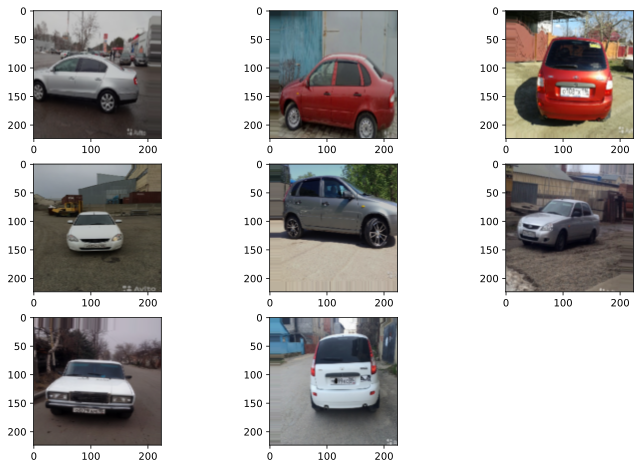

In [18]:
x,y = train_generator.next() # возвращает итератор на сгенерированный батч(первым аргументом)
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))
for i in range(0,8):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

Пример картинок из test_generator


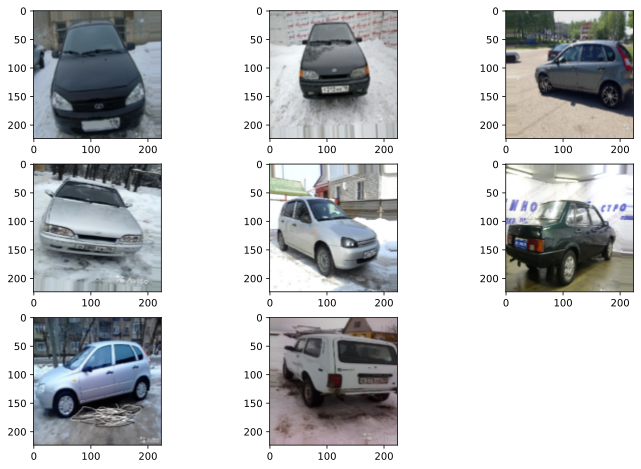

In [19]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,8):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

Видим, что, во-первых картинки приведены к одному размеру, во-вторых, осуществлены небольшие повороты, сдвиги, растяжения, изменилась яркость, появилось приближение/отдаление

# Построение модели

### Загружаем предобученную на imagenet сеть efficientnet:

In [20]:
import efficientnet.keras as efn

In [21]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

165527552/165527152 [==============================] - 7s 0us/step


Заморозим слои

In [22]:
base_model.trainable = False

In [23]:
base_model.input
# совпадает с тем, что выдает генератор данных, поэтому входной слой не меняем

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [24]:
#аналогично, но с добавлением Batch Normalization после полносвязного слоя
y = base_model.output
#вытягиваем в вектор
y = GlobalAveragePooling2D()(y)
# добавляем полносвязный слой, нормализацию, Dropout-регуляризацию
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
# и логистический слой
predictions = Dense(CLASS_NUM, activation='softmax')(y)

# итоговая модель:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [26]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 6


## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [27]:
# сохраняем всю модель после каждой эпохи
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max', save_freq="epoch",
                            save_best_only=False, save_weights_only=False)
#если после 3 эпох улучшений нет, останавливаемся
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

Обучаем:

In [28]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1654/1654 [==============================] - 368s 208ms/step - loss: 1.8804 - accuracy: 0.3777 - val_loss: 1.0528 - val_accuracy: 0.6303

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
1654/1654 [==============================] - 344s 208ms/step - loss: 1.3913 - accuracy: 0.5063 - val_loss: 0.9571 - val_accuracy: 0.6539

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
1654/1654 [==============================] - 343s 208ms/step - loss: 1.3016 - accuracy: 0.5339 - val_loss: 0.9197 - val_accuracy: 0.6767

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
1654/1654 [==============================] - 359s 217ms/step - loss: 1.2629 - accuracy: 0.5479 - val_loss: 0.8951 - val_accuracy: 0.6784

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
1654/1654 [==============================] - 352s 213ms/step - loss: 1.2225 - accuracy: 0.5658 - val_loss: 0.8661 - val_accuracy: 0.7033

Epoch 00005: saving model to best_model.hdf5


In [29]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [30]:
model.load_weights('best_model.hdf5')

In [31]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


292/292 [==============================] - 53s 180ms/step - loss: 0.8638 - accuracy: 0.6921
Accuracy: 69.21%


Точность 69.82%. Xception давала около 60% изначально с замороженными слоями
Посмотрим графики обучения:

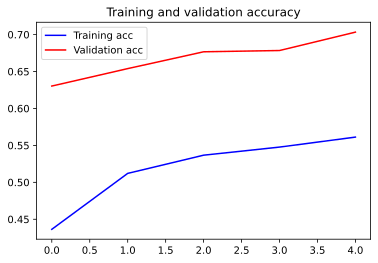

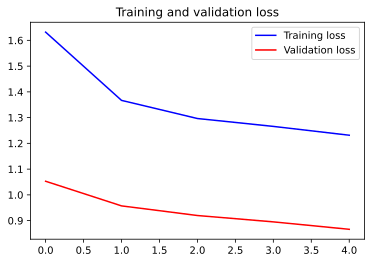

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Кажется, если бы эпох было побольше, результат мог улучиться. Продолжим обучение.

Используем fine-tuning.

## Fine-tuning
### Step 1

In [33]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 6


In [34]:
len(base_model.layers)//2

329

In [35]:
base_model.trainable = True
fine_tune_at = len(base_model.layers)//2 # обучаем половину сети, вторая половина - с теми же весами
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [36]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 297


In [37]:
LR = LR/10 # уменьшаем, чтобы не испортить веса 

In [38]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [39]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
1654/1654 [==============================] - 439s 250ms/step - loss: 1.3776 - accuracy: 0.5328 - val_loss: 0.3507 - val_accuracy: 0.8751

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
1654/1654 [==============================] - 408s 247ms/step - loss: 0.5659 - accuracy: 0.8026 - val_loss: 0.2548 - val_accuracy: 0.9064

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
1654/1654 [==============================] - 409s 247ms/step - loss: 0.4020 - accuracy: 0.8607 - val_loss: 0.2285 - val_accuracy: 0.9201

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
1654/1654 [==============================] - 413s 250ms/step - loss: 0.3076 - accuracy: 0.8964 - val_loss: 0.1900 - val_accuracy: 0.9322

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
1654/1654 [==============================] - 413s 250ms/step - loss: 0.2414 - accuracy: 0.9170 - val_loss: 0.1947 - val_accuracy: 0.9369

Epoch 00005: saving model to best_model.hdf5


In [40]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [41]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 50s 169ms/step - loss: 0.1981 - accuracy: 0.9347
Accuracy: 93.47%


После разморозки половины слоев стало 91.76%

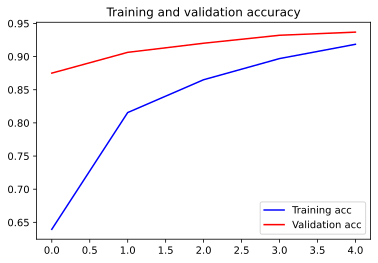

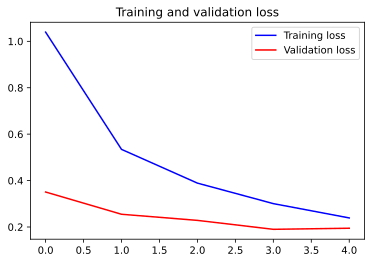

In [42]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
plot_history(history)

Разморозим еще слои

### Step 2

In [43]:
EPOCHS               = 5
BATCH_SIZE           = 4 # не влезает в память на GPU
IMG_SIZE             = 224 
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [44]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 297


In [45]:
train_datagen = ImageDataGenerator(  #уменьшим изменения
    rescale=1. / 255,
   # brightness_range=[0.75, 1.25], 
    #zoom_range=[0.5,1.5],
    rotation_range = 5, #поварачиваем картинке на угол [0,5] градусов
   # width_shift_range=0.1,#процент от всего изображения, на который смещаем по ширине (сдвиг в диапазоне [0, 0.1])
    height_shift_range=0.1, #процент от всего изображения, на который смещаем по высоте
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

In [46]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория, где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [47]:
LR = LR/10

In [48]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [49]:
y = base_model.output
#вытягиваем в вектор
y = GlobalAveragePooling2D()(y)
# добавляем полносвязный слой, нормализацию, Dropout-регуляризацию
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
# и логистический слой
predictions = Dense(CLASS_NUM, activation='softmax')(y)

# итоговая модель:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [50]:
model.load_weights('best_model.hdf5')

In [51]:
base_model.trainable = True
fine_tune_at = len(base_model.layers)//4 # размораживаем 75%
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [52]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 441


In [53]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - 841s 245ms/step - loss: 0.3891 - accuracy: 0.8776 - val_loss: 0.1542 - val_accuracy: 0.9553

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
3308/3308 [==============================] - 806s 244ms/step - loss: 0.3066 - accuracy: 0.9063 - val_loss: 0.1510 - val_accuracy: 0.9519

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
3308/3308 [==============================] - 804s 243ms/step - loss: 0.3049 - accuracy: 0.9021 - val_loss: 0.1438 - val_accuracy: 0.9558

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
3308/3308 [==============================] - 817s 247ms/step - loss: 0.2564 - accuracy: 0.9182 - val_loss: 0.1441 - val_accuracy: 0.9584

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
3308/3308 [==============================] - 816s 247ms/step - loss: 0.2353 - accuracy: 0.9240 - val_loss: 0.1467 - val_accuracy: 0.9558

Epoch 00005: saving model to best_model.hdf5


In [54]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 51s 87ms/step - loss: 0.1493 - accuracy: 0.9622
Accuracy: 96.22%


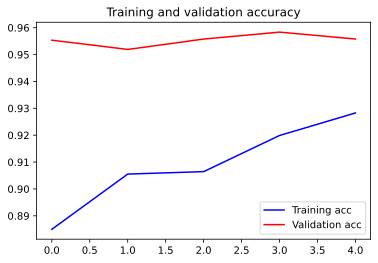

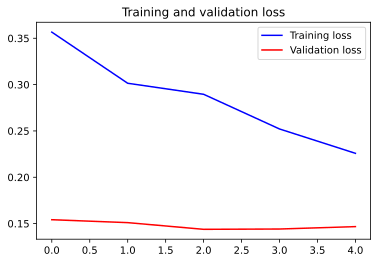

In [55]:
plot_history(history)

Прирост есть. Дообучим всю сеть

### Step 3

In [56]:
base_model.trainable = True
LR=LR/10
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [57]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 5,
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - 861s 250ms/step - loss: 0.2198 - accuracy: 0.9310 - val_loss: 0.1427 - val_accuracy: 0.9566

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
3308/3308 [==============================] - 805s 243ms/step - loss: 0.2143 - accuracy: 0.9305 - val_loss: 0.1465 - val_accuracy: 0.9571

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
3308/3308 [==============================] - 801s 242ms/step - loss: 0.2094 - accuracy: 0.9339 - val_loss: 0.1459 - val_accuracy: 0.9584

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
3308/3308 [==============================] - 802s 242ms/step - loss: 0.2018 - accuracy: 0.9357 - val_loss: 0.1449 - val_accuracy: 0.9575

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
3308/3308 [==============================] - 815s 246ms/step - loss: 0.2038 - accuracy: 0.9345 - val_loss: 0.1434 - val_accuracy: 0.9579

Epoch 00005: saving model to best_model.hdf5


In [58]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [59]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 50s 86ms/step - loss: 0.1411 - accuracy: 0.9588
Accuracy: 95.88%


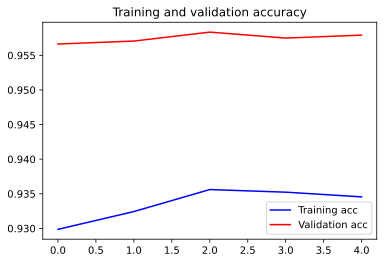

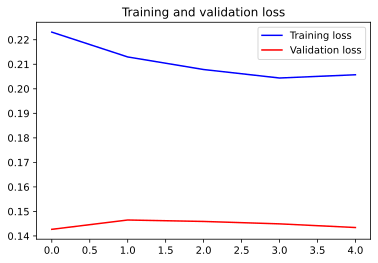

In [60]:
plot_history(history)

Результат немного ухудшился

### Step 4

Подадим картинку большего размера

In [61]:
IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
 #   brightness_range=[0.75, 1.25], 
    #zoom_range=[0.5,1.5],
    rotation_range = 5, #поварачиваем картинке на угол [0,5] градусов
   # width_shift_range=0.1,#процент от всего изображения, на который смещаем по ширине (сдвиг в диапазоне [0, 0.1])
   # height_shift_range=0.1, #процент от всего изображения, на который смещаем по высоте
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [63]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория, где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [64]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

In [65]:
y = base_model.output
#вытягиваем в вектор
y = GlobalAveragePooling2D()(y)
# добавляем полносвязный слой, нормализацию, Dropout-регуляризацию
y = Dense(256, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
# и логистический слой
predictions = Dense(CLASS_NUM, activation='softmax')(y)

# итоговая модель:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [66]:
model.load_weights('best_model.hdf5')

In [67]:
print('Всего слоев:', len(model.layers))
print('Обучаемых:', len(model.trainable_variables))

Всего слоев: 664
Обучаемых: 588


In [68]:
i = 0
for layer in model.layers:
    if (layer.trainable==False):
        i=i+1
        print(i, layer.trainable)#вроде все обуается

In [69]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 5,  #
        callbacks = callbacks_list
)

Epoch 1/5
3308/3308 [==============================] - 2422s 723ms/step - loss: 0.7019 - accuracy: 0.7779 - val_loss: 0.1909 - val_accuracy: 0.9442

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
3308/3308 [==============================] - 2373s 717ms/step - loss: 0.5140 - accuracy: 0.8377 - val_loss: 0.1479 - val_accuracy: 0.9588

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
3308/3308 [==============================] - 2362s 714ms/step - loss: 0.4642 - accuracy: 0.8500 - val_loss: 0.1420 - val_accuracy: 0.9644

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
3308/3308 [==============================] - 2362s 714ms/step - loss: 0.3924 - accuracy: 0.8829 - val_loss: 0.1338 - val_accuracy: 0.9631

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
3308/3308 [==============================] - 2359s 713ms/step - loss: 0.3501 - accuracy: 0.8875 - val_loss: 0.1259 - val_accuracy: 0.9652

Epoch 00005: saving model to best_model.hdf5


In [70]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [71]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 157s 269ms/step - loss: 0.1323 - accuracy: 0.9639
Accuracy: 96.39%


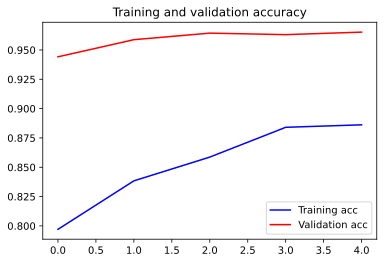

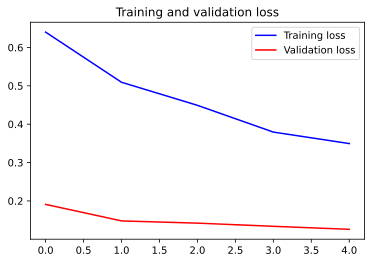

In [72]:
plot_history(history)

# Предсказание на тестовых данных

In [73]:
model.load_weights('../input/best-md/best_model.hdf5')

In [74]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


### TTA

In [75]:
#TTA
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 184s 110ms/step


In [76]:
 pred = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 

1669/1669 [==============================] - 185s 111ms/step


In [77]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_5.csv', index=False)
print('Save submit')

Save submit


In [78]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,7


In [79]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

## Итоги

В проекте применены:

* transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
* технка изменения аугментации и learning rate на каждом новом шаге fine-tining
* дополнительная функция EarlyStopping в Keras callbacks
* настройка LR(попытка подбора руками)
* выбор архитекруры головы предобученной сети
* подобраны переменные (размер картинки, батч, количество эпох)
* SOTA архитектура сетей - Xception, EfficientNetB6. EfficientNetB6, как и ожидалось, дала лучший результат.
* Test Time Augmentation

Итоговый результат на тестовой выборке: 